# Singular Value Decomposition (SVD)

> "A singularly valuable decomposition" 
>--Dan Kalman 

> "Singular Value Decomposition. Love it, learn it."
>--Michael Basial

> "SVD? Magic, simply magic."
>--John Doherty

 As we've said, the key to representative environmental models is allowing high levels of flexibility through a highly parameterized approach.  But this makes our parameter estimation problem ill-posed and underdetermined, which means our solution is nonunique even if we overcome problems of increased instability and longer runtimes.  Here we use a "regularized inversion" approach to overcome these problems.  Regularization is anything that makes an intractable problem solvable; for example, using a small number of zones (not highly-parameterized) is a way to regularize an illposed problem.  Regularization as we use here can be grouped into two broad categories: 
 1. adding soft-knowledge to the problem (Tikhonov regularization) and 
 2. mathematically reducing the dimensionality of the model (subspace regularization via singular value decomposition (SVD)). In practice we typically use a combination ("hybrid") of these two approaches. 

 It is worth expounding on this difference in regularization approaches. In contrast to Tikhonov regularization, which adds information to the calibration process to achieve numerical stability, subspace methods achieve stability through subtracting parameters, and/or parameter combinations, from the calibration process (making a "subspace" of the full parameter space). Now the calibration process is no longer required to estimate either individual parameters or combinations of correlated parameters that are inestimable given the calibration dataset we have. What combinations are estimable are automatically determined through SVD. 

 The effort needed to take advantage of these regularization strategies is also appreciably different, where SVD is relatively easily brought to bear and becomes "set it and forget it". Moreover, when SVD is used the parameter estimation problem always becomes __unconditionally stable__! Neither of these is true in all cases when adding soft knowledge using Tikhonov regularization. 

 In summary, SVD benefits apply to all models so it is worth widely invoking when using PEST and PEST++.  SVD involves few parameter estimation inputs, default values work for a large range of problems, and it addresses instability for all problems. Can you catch that we can't overemphasize the importance of SVD to parameter estimation?  "Magic" indeed! 


In this and the next notebooks we'll get under the hood of SVD and see what it does.  A high-level understanding is not needed to take advantage of the power of SVD for your typical calibration parameter estimation problem ("set it and forget it").  BUT in addition to the glow of knowledge that they impart, these SVD concepts will cascade into understanding other tools such as parameter identifiability, calculation of uncertainty, and null-space Monte Carlo.  

> #### We highly recommend going through:
> - Gregory Gunderson's [Singular Value Decomposition as Simply as Possible](https://gregorygundersen.com/blog/2018/12/10/svd/#:~:text=The%20singular%20values%20referred%20to,our%20transformation%20flattens%20our%20square.). An excellent place to start to gain an intuitive understanding of SVD. 
> -  Frank Cleary's [introduction to SVD notebook](https://gist.github.com/frankcleary/a89da479d85c98f86e31).

## Matrices

Linear Algebra is the foundation of much of our maths and modeling. At the basis of this is matrices, which are containing vector information like spatial array of properties, mappings from one set of properties to another, the variability of properties.

 Another example of a matrix is just a photograph. It turns out, much of the information contained in a matrix is redundant. If we think of the columns of a matrix as vectors, they are orthogonal but maybe aren't quite the right basis for the infromation. What if we could find another basis, where we rotate to a more suitable set of orthogonal basis vectors and maybe even stretch them?

Any matrix can be decomposed into 3 matrices:
$$\mathbf{M}=\mathbf{U}\mathbf{S}\mathbf{V}^T$$

In [1]:
%matplotlib inline
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sys.path.append("..")
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
""
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm     
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

import numpy as np
import shutil 

noPIL=False
try:
    from PIL import Image
except:
    noPIL=True

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

## An Image is also a Matrix
Let's evaluate how this works by exploring the information content in an image.

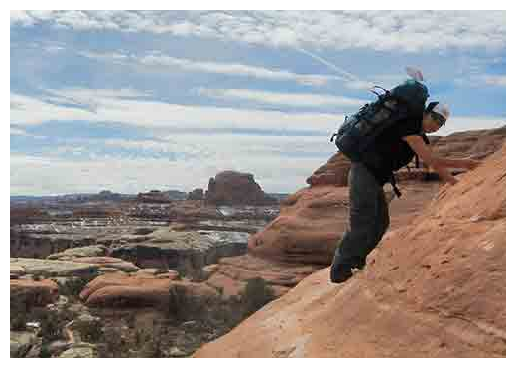

In [2]:
photo = Image.open('clands.jpg')

plt.imshow(photo, interpolation='nearest')
plt.axis('off');

### Convert to grayscale

By converting to grayscale, what we are left with is a matrix of information where each pixel (e.g. a cell in rows/columns of the matrix) has a value between 0 and 255 indicating intensity. This is then just a matrix with information in it.

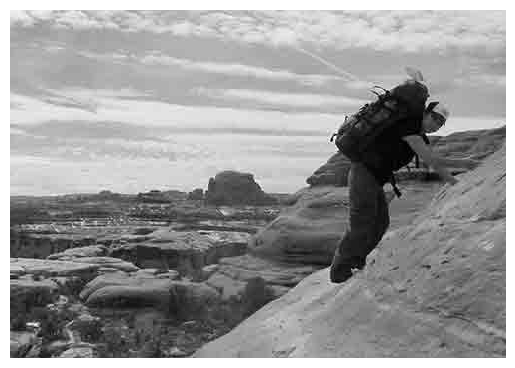

In [3]:
if not noPIL:
    photogray = np.array(photo.convert('L'))
    np.savetxt('clands_gray.dat', photogray, fmt='%d')
else:
    photogray = np.loadtxt('clands_gray.dat', dtype=int)
plt.imshow(photogray, interpolation='nearest', cmap='gray')
plt.axis('off');

We can treat this like any matrix and perform SVD. In python, `numpy` makes this easy. (_Go through Frank Clearly's [notebooks](https://gist.github.com/frankcleary/a89da479d85c98f86e31) for details on the maths behind all of this._)

In the next cell we use `numpy` to  decompose the `photogray` matrix using the equiation shown earlier: $\mathbf{M}=\mathbf{U}\mathbf{S}\mathbf{V}^T$

In [4]:
U, sigma, V = np.linalg.svd(photogray,)

`sigma` is a 1D array that contains the singular values of `photogray`. $\mathbf{S}$ = `np.diag(sigma)`. Singular values provide a measure of the "amount of information" in each vector. So, the first column of $\mathbf{U}$ and row of $\mathbf{V}^T$ contain the most information, the second the second most, and so on.

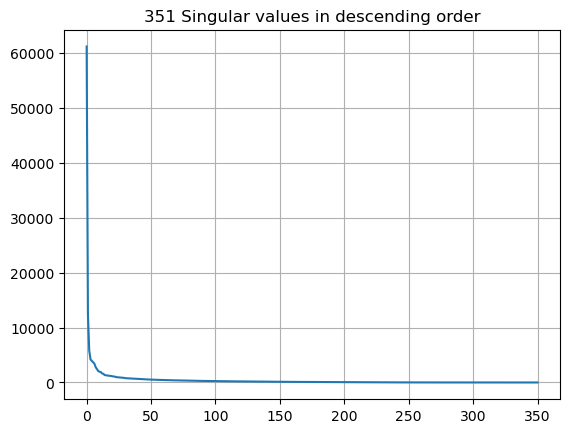

In [5]:
plt.plot(sigma)
plt.grid()
plt.title('{0} Singular values in descending order'.format(len(sigma)));

The same thing on a $Log_{10}$ scale:

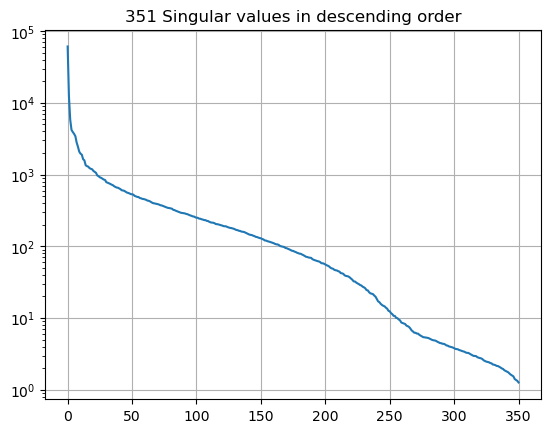

In [6]:
plt.plot(sigma)
plt.grid()
plt.title('{0} Singular values in descending order'.format(len(sigma)));
plt.yscale('log');

Let's make a little function for using a subset of singular values to reconstitute the image:

In [7]:
def recon_image(U,sigma,V,numsing=1, photo=None, printflag=False):
    #reconimg = USV
    reconimg = np.dot(np.dot(U[:,:numsing], np.diag(sigma[:numsing])),V[:numsing,:])
    basis_vec = np.dot(np.dot(np.atleast_2d(U[:,numsing-1]).T, sigma[numsing-1]),np.atleast_2d(V[numsing-1,:]))
    fig,ax = plt.subplots(ncols=2, figsize=(12,12))
    ax[0].imshow(basis_vec, interpolation='nearest', cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Basis Image')
    ax[1].imshow(reconimg, interpolation='nearest', cmap='gray')
    ax[1].axis('off')
    ss = 's'
    if numsing==1:
        ss = ''
    ax[1].set_title('Reconstruction using {0} singular value{1}'.format(numsing,ss))
    plt.tight_layout()
    if printflag==True:
        plt.savefig(os.path.join('pngs','svd_{0}.png'.format(numsing)), bbox_inches='tight', pad_inches=0.2)
        plt.close()
    return basis_vec


What this function is doing is computing an approximation of the image (the matrix) using `numsing` number of vectors of the singular value decomposition. Recall from above that we have a maximum of 350 singular values.

Computing an approximation of the image using the first column of $\mathbf{U}$ and first row of $\mathbf{V}^T$ reproduces the most prominent features of the image. The left panel shows the unique information contributed by the current singular value (and associated vectors), and the right panel shows the combination of all the singular values up to `numsing` used to reconstruct the image: 

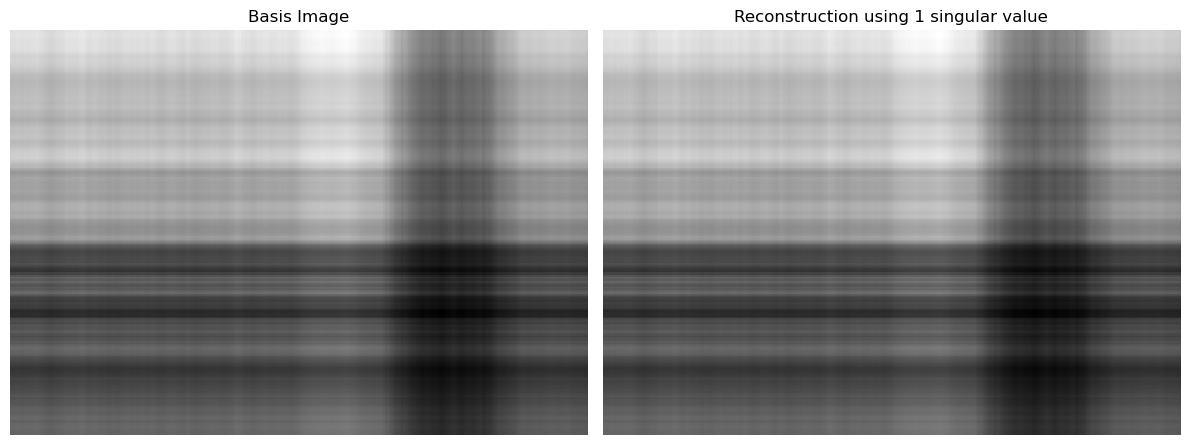

In [8]:
rec=recon_image(U,sigma,V,1)

But how many are "enough"? Check out the plots of singular values above. At what _number of singular values_ (x-axis) do the _singular values_ (y-axis) start to flatten out? Somewhere around 25? This  suggests that all the “action” of the matrix happens along only these few dimensions. So we should be able to reconstruct a decent approximation with only 25 pieces of information, instead of the total 350:

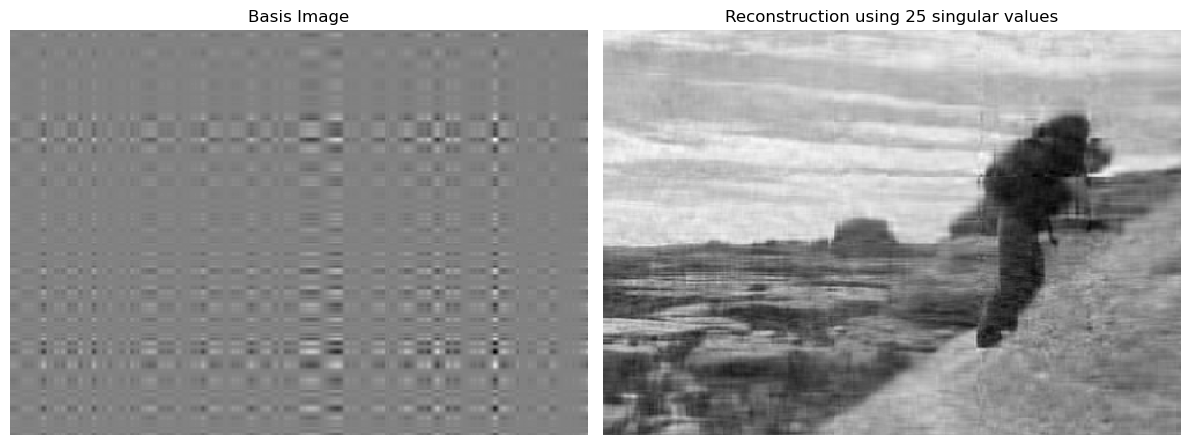

In [9]:
rec=recon_image(U,sigma,V,25)

Hey that's pretty good! And with a fraction of the total information.

# What does this have to do with groundwater modeling?

Let's cook up a Jacobian Matrix. You should be familiar with this process now. We are going to re-construct the Freyberg pilot point PEST setup. Then run PEST++GLM once, with NOPMAX set to -1 to calculate a Jacobian matrix.

In [10]:
sys.path.insert(0,"..")
import herebedragons as hbd

# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)
# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)
# convenience function that builds a new control file with pilot point parameters for hk
hbd.add_ppoints(tmp_d)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

Run PEST++GLM:

In [11]:
pst = pyemu.Pst(os.path.join(tmp_d,'freyberg_pp.pst'))
pst.control_data.noptmax = -1
pst.write(os.path.join(tmp_d, 'freyberg_pp.pst'))
m_d = 'master_pp'
num_workers=6
pyemu.os_utils.start_workers(tmp_d, # the folder which contains the "template" PEST dataset
                            'pestpp-glm', #the PEST software version we want to run
                            'freyberg_pp.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

noptmax:-1, npar_adj:65, nnz_obs:37


             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.2.6
binary compiled on Aug 15 2023 at 16:48:53

started at 11/21/23 14:29:13
...processing command line: ' ./pestpp-glm freyberg_pp.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "freyberg_pp.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part0_intro_to_svd/master_pp"
on host: "IGSACB116LHMNFI"

processing control file freyberg_pp.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... .. 

## Form up the normal equations matrix

This matrix is $\mathbf{X}^T\mathbf{Q}\mathbf{X}$. The Jacobian matrix contains values for $\mathbf{X}$. The observation noise is represented by $\mathbf{Q}$.

Let's get to our Jacobian:

In [12]:
injac = pyemu.Jco.from_binary(os.path.join(m_d, 'freyberg_pp.jcb'))

X = injac.df().values

A Jacobian matrix is...a matrix! Rows are observations, columns are parameters. The plot below displays parameter sensitivities:

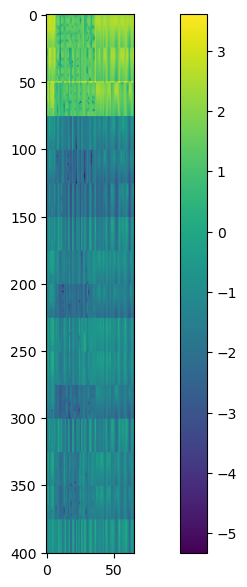

In [13]:
fig= plt.figure(figsize=(12,7))
plt.imshow(np.log10(abs(X )))
plt.colorbar();

We can also get our matrix of observation noise from the weights in the PEST control file (this assumes that observation weights are the inverse of observation noise and that noise is independent):

In [14]:
inpst = pyemu.Pst(os.path.join(m_d,'freyberg_pp.pst'))
Q = inpst.observation_data.weight.values
Q = np.diag(Q)
Q

array([[0.005, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.005, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.005, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

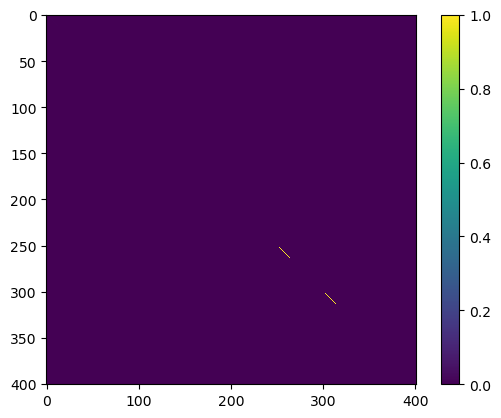

In [15]:
#plt.figure(figsize=(15,15))
plt.imshow(Q, interpolation='nearest', cmap='viridis')
plt.colorbar()

## Back to SVD

We can now undertake SVD on the normal matrix $\mathbf{X^tQX}$.

In [16]:
XtQX=X.T.dot(Q).dot(X)

Just as we did above for the photograph:

In [17]:
U, sigma, V = np.linalg.svd(XtQX)

Plot the singular values (note the log-10 scale on the y-axis). Note that the total number of singular values matches the number of weighted observations in the PEST control file. Why? Because that is the total "amount" of information we have available to inform parameters.

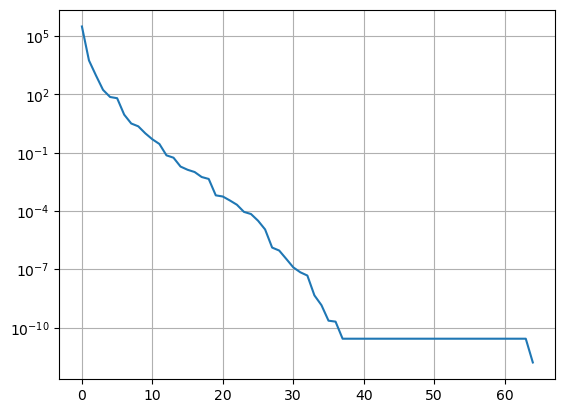

In [18]:
plt.plot(sigma)
plt.yscale('log')
plt.grid()

If you want to get fancy, you can explore which parameters inform which singular value vector. The interactive plot below allows you to select the singular vect, and plots the parameter contributions to it:

In [19]:
hbd.interactive_sv_vec_plot(inpst, U);

/Users/mnfienen/opt/miniconda3/envs/gmdsitut/lib/python3.10/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`


interactive(children=(IntSlider(value=1, description='Number SVs:', max=20, min=1), Output()), _dom_classes=('…

### Great - finally how does this impact our calibration of a K-field?

The function below pulls in the "true" hydraulic conductivity from our Freyberg model:

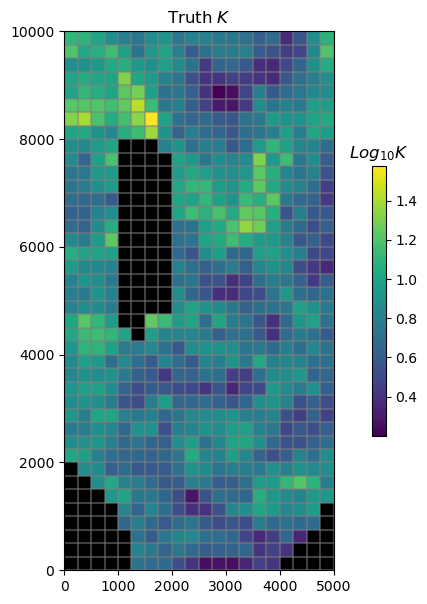

In [20]:
gwf = hbd.plot_truth_k(m_d);

## Now reconstruct the K field

Let's see if we can reconstruct this field.

The next cell implements a function similar to what we did for the image at the start of this notebook and plots the outcomes.

Play with the slider in the figure below. As you move it to the right, more singular values are employed. After a certain number of SVs, the reconstructed parameter field starts to become similar to the true field. Magic.

In [21]:
hbd.svd_enchilada(gwf, m_d);

   could not remove start_datetime


interactive(children=(IntSlider(value=400, description='eig comp:', max=799), Output()), _dom_classes=('widget…